# FYP OSNR: Graphs and Visualisations

Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

Set the plotting style:

In [2]:
try:
    scientific_style = [
        'C:/Users/seani/Documents/JupyterNotebooks/Random/PythonTutorialsForDataScience/data/science.mplstyle', 
        'C:/Users/seani/Documents/JupyterNotebooks/Random/PythonTutorialsForDataScience/data/notebook.mplstyle', 
        'C:/Users/seani/Documents/JupyterNotebooks/Random/PythonTutorialsForDataScience/data/grid.mplstyle'
    ]

    plt.style.use(scientific_style)
    
    print('Using Scientific Style.')
except:
    print('Missing Scientific Style, continuing with default.')

Using Scientific Style.


## Importing and assigning signals

Function to match signals:

In [3]:
def get_match_window(t, signal, signal_window):
    # set sum of squared errors to infinity
    sse = np.inf
    # initialise the signal we return as our current signal
    new_signal = signal.copy()
    
    # loop through each element
    for i in range(len(t)):
        # roll the array so that i values at end are moved to start
        # then only look at the same number of values as the signal window
        # this means that we are directly the window to the signal
        test_signal = np.roll(signal, i)[:len(signal_window)]
        # get the sse of this test signal compared to the window signal
        test_sse = sum(np.abs(test_signal - signal_window)**2)
        # if the new sse is smaller than previous
        if test_sse < sse:
            # set new sse
            sse = test_sse
            # set new signal
            # ignoring windowing
            new_signal = np.roll(signal, i)
    
    return new_signal

The signal we will match to with indices:

In [4]:
# import the on data from the text file
t_on, signal_on = np.loadtxt(f'Data/on_channels/reading_003.txt', delimiter=',', skiprows=1).T
# fix data by only taking first second of it (as it is periodic with 1s), total data is 2s long so half it
t_on = t_on[:len(t_on)//2]
signal_on = signal_on[:len(signal_on)//2]

# the markers to use
marker_81 = 530
marker_87 = 570
# create an array of only this window of the on signal
marker_window = signal_on[marker_81:marker_87]

Converting to frequencies and dBm:

In [5]:
# points defining
t1, t2 = 0.292, 0.49
freq1, freq2 = 194.3945, 195.696

# parameters of line
slope = (freq2 - freq1) / (t2 - t1)
intercept = freq1 - slope * t1

# make as a function
s_to_THz = lambda t: slope * t + intercept

In [6]:
# max of watts to max of voltage
watt_conversion = 4.2150234972104395e-07 / 1.421254738842842

# create a function to convert voltage to dBm
V_to_dBm = lambda voltage: 10 * np.log10(1000 * voltage * watt_conversion)

Import assign, and match the channel sim values:

In [7]:
sim_freqs = []
sim_signals = []
for i in range(0, 200):
    # import the data from the text file
    t, signal = np.loadtxt(f'Data/channel_sim/reading_{i:03}.txt', delimiter=',', skiprows=1).T
    # fix data by only taking first second of it (as it is periodic with 1s), total data is 2s long so half it
    t = t[:len(t)//2]
    signal = signal[:len(signal)//2]
    
    # fix the signal so it is in the center
    # do this by matching the on signal window with the signal
    # but must roll by the marker_81 value to make sure we index properly
    # clip so that anything below 10^-4 is set to 10^-4
    # then convert to dBm
    fixed_signal = V_to_dBm(np.roll(get_match_window(t, signal, marker_window), marker_81).clip(min=10**(-4)))
    sim_signals.append(fixed_signal)
    
    # now convert time to frequency
    freq = s_to_THz(t)
    sim_freqs.append(freq)

Likewise with the channel sim but channel 54 turned off:

In [8]:
sim54_freqs = []
sim54_signals = []
for i in range(0, 200):
    # import the data from the text file
    t, signal = np.loadtxt(f'Data/channel_sim_54off/reading_{i:03}.txt', delimiter=',', skiprows=1).T
    # fix data by only taking first second of it (as it is periodic with 1s), total data is 2s long so half it
    t = t[:len(t)//2]
    signal = signal[:len(signal)//2]
    
    # fix the signal so it is in the center
    # do this by matching the on signal window with the signal
    # but must roll by the marker_81 value to make sure we index properly
    # clip so that anything below 10^-4 is set to 10^-4
    # then convert to dBm
    fixed_signal = V_to_dBm(np.roll(get_match_window(t, signal, marker_window), marker_81).clip(min=10**(-4)))
    sim54_signals.append(fixed_signal)
    
    # now convert time to frequency
    freq = s_to_THz(t)
    sim54_freqs.append(freq)

Now assign the OSNR data taken from `OSNR_measuring.ipynb`:

In [9]:
# sim OSNRs
sim_OSNR_rel = np.array(
    [5.27342622, 5.05657961, 4.96435941, 4.88710812, 
     4.89897466, 5.11116452, 4.91303660, 4.64712890, 
     4.56342067, 4.66558666, 4.67071941, 4.35977830, 
     4.76160713]
)
sim_OSNR = np.array(
    [14.65947973, 14.45509383, 15.11637982, 13.87571363, 
     14.02278668, 14.03533906, 13.94772412, 14.04201740, 
     13.76832670, 13.59892559, 12.68179280, 12.79123810, 
     12.97065174]
)
sim_OSNR = np.array([14.85538335, 14.63094116, 14.8210314 , 14.0305314 , 14.08295123,
       14.10844472, 13.98927724, 14.08581681, 13.44748135, 13.47705876,
       13.45465238, 12.75042549, 12.99389436])

# OSA OSNRs
OSA_OSNR_rel = np.array(
    [50.2600, 50.4685, 50.3385, 49.9425, 
     50.0200, 50.4030, 49.7995, 48.7785, 
     48.7215, 48.9435, 48.4050, 47.4965, 
     46.7440]
)
OSA_OSNR = np.array(
    [53.08084394, 53.09861856, 53.49890000, 53.43784735, 
     53.50171402, 53.53950568, 52.58826477, 51.63134811, 
     51.98322159, 50.69222955, 50.80629621, 49.36417008, 
     49.12994735]
)

The frequency of each simulated channel is as follows:

In [10]:
channels_THz = np.array(
    [195.69639741, 195.60003549, 195.50699408, 195.39641377, 
     195.29075440, 195.196405540, 195.092561970, 194.995208250, 
     194.90073920, 194.798007320, 194.696976860, 194.601204840, 
     194.49799343]
)

## Plotting results

We can plot all the channel sim data as follows, with a fill between. Ignore `signal 000` as this had an excessive amount of noise:

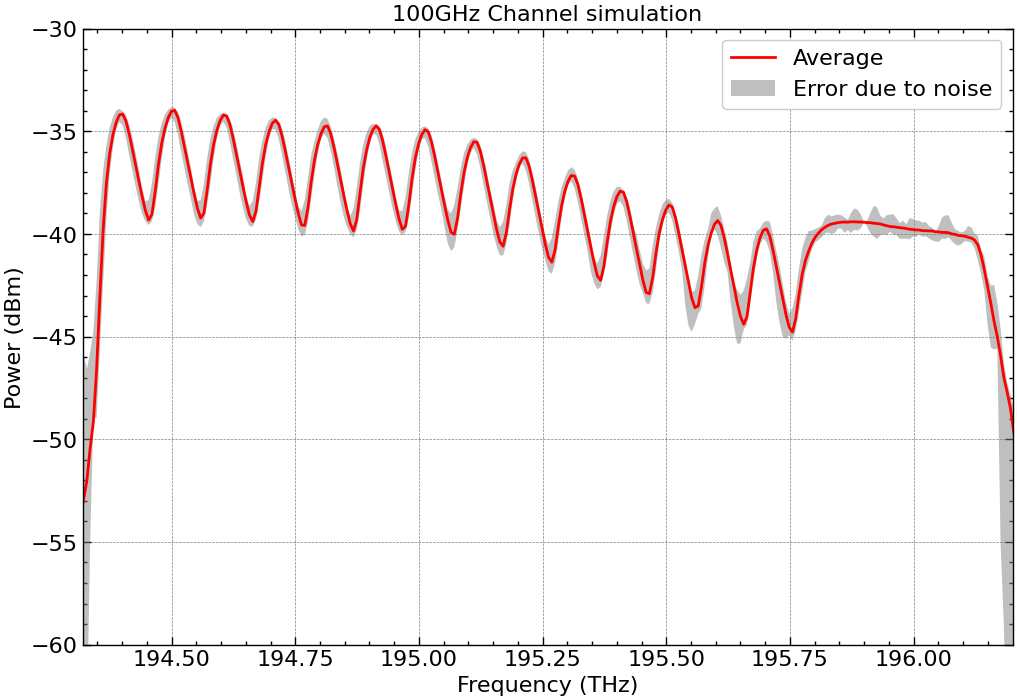

In [11]:
# signal processing
min_signal = savgol_filter(np.array(sim_signals[1::4]).min(axis=0), 6, 3)
max_signal = savgol_filter(np.array(sim_signals[1::4]).max(axis=0), 6, 3)

# PLOTTING
fig, ax = plt.subplots(
        1,
        1,
        figsize=(12, 8),
    )

ax.plot(sim_freqs[0], np.array(sim_signals[1:]).mean(axis=0), 'r', label='Average')
#ax.plot(sim_freqs[0], np.array(sim_signals[1:]).min(axis=0), 'b--', label='Minimum')
#ax.plot(sim_freqs[0], np.array(sim_signals[1:]).max(axis=0), 'g--', label='Maximum')
ax.fill_between(sim_freqs[0], min_signal, max_signal, facecolor="gray", alpha=0.5, label='Error due to noise')

ax.legend()

ax.set_xlim(194.32, 196.2)
ax.set_ylim(-60, -30)

ax.set_ylabel('Power (dBm)')
ax.set_xlabel('Frequency (THz)')

ax.set_title('100GHz Channel simulation')

#plt.savefig('100GHz_sim.jpg', bbox_inches='tight')

We can then do the same for the same simulation but turning channel 54 off. The following indices had excessive noise and were discarded:

``signal 003``  
``signal 024``  
``signal 029``  
``signal 047``  
``signal 056``  
``signal 088``  
``signal 099``  
``signal 147``  
``signal 148``  
``signal 158``  
``signal 185``  
``signal 191``  
``signal 192``  
``signal 193``  

Text(0.5, 1.0, '100GHz Channel simulation with one channel switched off')

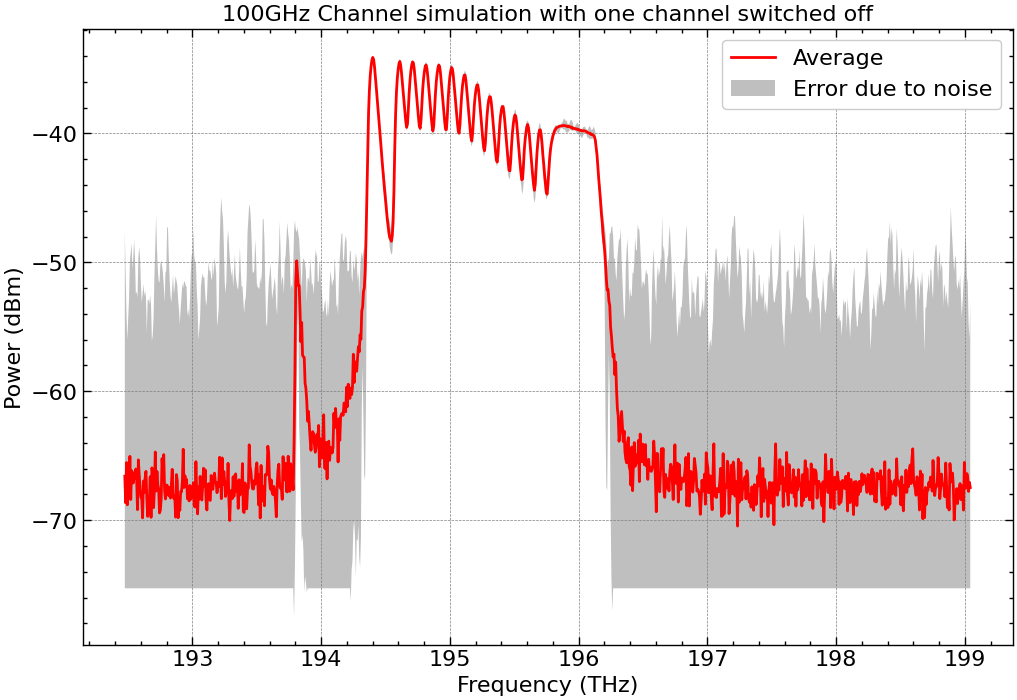

In [12]:
# delete the indices specified
use_list = [3, 4, 9, 12, 14, 15, 20, 21, 22, 23, 24, 25, 28, 29, 32, 34, 36, 37, 38, 47, 53, 56, 67, 68, 88, 99, 122, 123, 127, 147, 148, 158, 161, 164, 165, 166, 167, 184, 185, 186, 187, 189, 191, 192, 193, 196, 197, 198]
use_signals = np.delete(sim54_signals, use_list, 0)[::4]

min_signal = savgol_filter(np.array(use_signals).min(axis=0), 7, 3)
max_signal = savgol_filter(np.array(use_signals).max(axis=0), 7, 3)

# PLOTTING
fig, ax = plt.subplots(
        1,
        1,
        figsize=(12, 8),
    )

ax.plot(sim54_freqs[0], np.array(use_signals).mean(axis=0), 'r', label='Average')
#ax.plot(sim54_freqs[0], np.array(use_signals).min(axis=0), 'b--', label='Minimum')
#ax.plot(sim54_freqs[0], np.array(use_signals).max(axis=0), 'g--', label='Maximum')
ax.fill_between(sim54_freqs[0], min_signal, max_signal, facecolor="gray", alpha=0.5, label='Error due to noise')

ax.legend()

#ax.set_xlim(194.32, 196.2)
#ax.set_ylim(-60, -30)

ax.set_ylabel('Power (dBm)')
ax.set_xlabel('Frequency (THz)')

ax.set_title('100GHz Channel simulation with one channel switched off')

#plt.savefig('100GHz_oneoff_sim.jpg', bbox_inches='tight')

And now we can plot the OSNR data together:

Parameters:


array([-4.76405410e+00,  1.86256727e+03, -1.81995170e+05])

Covariance Matrix:


array([[ 7.34572167e-01, -2.86629228e+02,  2.79604971e+04],
       [-2.86629228e+02,  1.11842481e+05, -1.09101701e+07],
       [ 2.79604971e+04, -1.09101701e+07,  1.06428162e+09]])

Errors in each parameter:


array([8.57071856e-01, 3.34428589e+02, 3.26233294e+04])

% Errors in each parameter:


array([17.99038884, 17.95524884, 17.92538202])

Parameters:


array([-2.36171383e-01,  9.37469109e+01, -9.28645349e+03])

Covariance Matrix:


array([[ 4.98807548e+00, -1.94634086e+03,  1.89864249e+05],
       [-1.94634086e+03,  7.59460340e+05, -7.40849015e+07],
       [ 1.89864249e+05, -7.40849015e+07,  7.22694302e+09]])

Errors in each parameter:


array([2.23339998e+00, 8.71470218e+02, 8.50114288e+04])

% Errors in each parameter:


array([945.66918037, 929.59886314, 915.43481957])

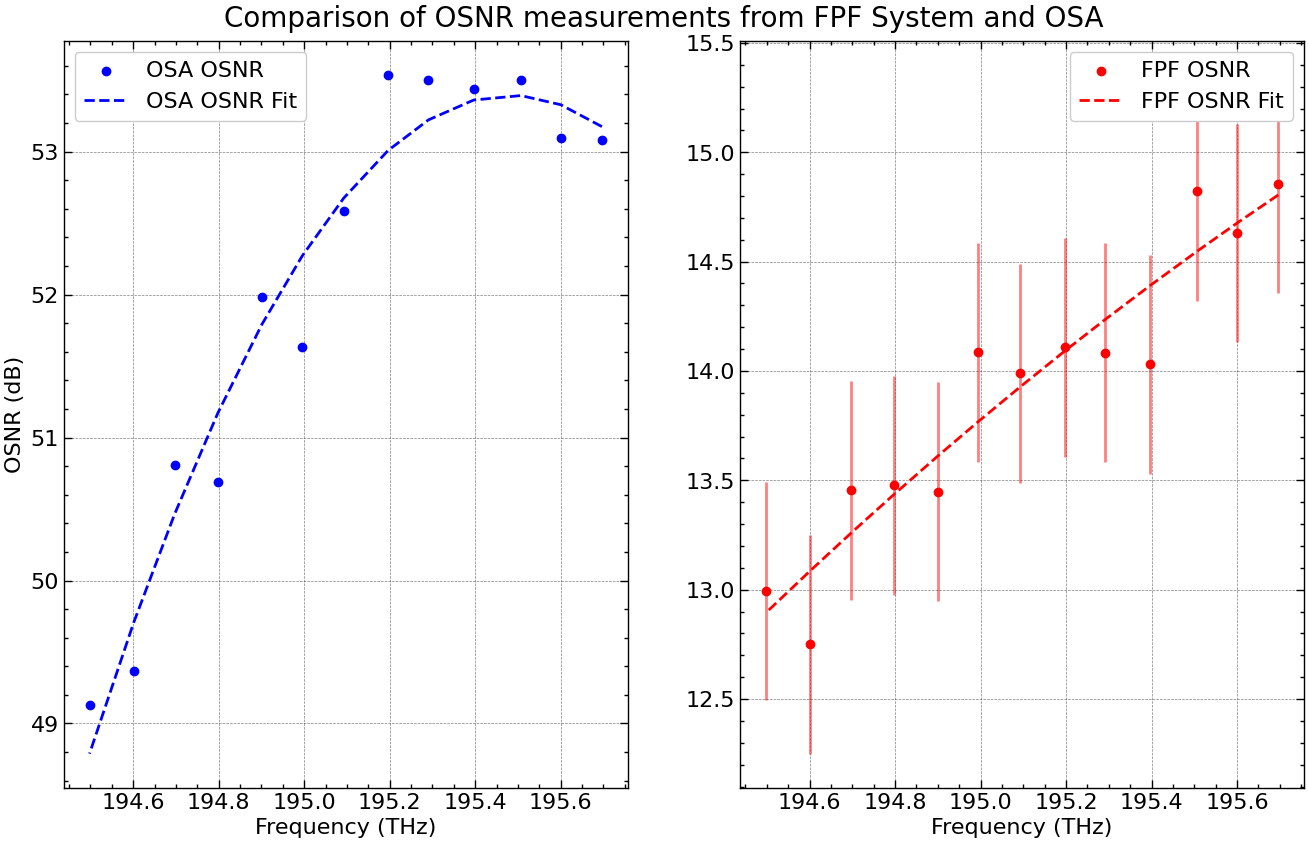

In [14]:
# FITTING

def quadratic(x, A, B, C):
    return A * x**2 + B * x + C

def cubic(x, A, B, C, D):
    return A * x**3 + B * x**2 + C * x + D

def quartic(x, A, B, C, D, E):
    return A * x**4 + B * x**3 + C * x**2 + D * x + E

# OSA

OSA_popt, OSA_pcov = curve_fit(quadratic, channels_THz, OSA_OSNR, p0=[-1, -1, -1])

print('Parameters:')
display(OSA_popt)

print('Covariance Matrix:')
display(OSA_pcov)

print('Errors in each parameter:')
display(np.sqrt(np.diag(OSA_pcov)))

print('% Errors in each parameter:')
display(100 * np.sqrt(np.diag(OSA_pcov)) / np.abs(OSA_popt))

# System

sim_popt, sim_pcov = curve_fit(quadratic, channels_THz, sim_OSNR, p0=[-1, -1, -1], sigma=[1]*len(sim_OSNR), absolute_sigma=True)

print('Parameters:')
display(sim_popt)

print('Covariance Matrix:')
display(sim_pcov)

print('Errors in each parameter:')
display(np.sqrt(np.diag(sim_pcov)))

print('% Errors in each parameter:')
display(100 * np.sqrt(np.diag(sim_pcov)) / np.abs(sim_popt))

# PLOTTING
fig, axes = plt.subplots(
        1,
        2,
        figsize=(16, 9),
    )

axes[0].scatter(channels_THz, OSA_OSNR, color='b', marker='o', label='OSA OSNR')
axes[0].plot(channels_THz, quadratic(channels_THz, *OSA_popt), color='b', ls='--', label='OSA OSNR Fit')

axes[0].legend()

axes[0].set_xlabel('Frequency (THz)')
axes[0].set_ylabel('OSNR (dB)')

axes[1].scatter(channels_THz, sim_OSNR, color='r', marker='o', label='FPF OSNR')
axes[1].errorbar(channels_THz, sim_OSNR, yerr=0.5, ls='', color='r', alpha=0.5)
axes[1].plot(channels_THz, quadratic(channels_THz, *sim_popt), color='r', ls='--', label='FPF OSNR Fit')

axes[1].legend()

axes[1].set_xlabel('Frequency (THz)')

fig.suptitle('Comparison of OSNR measurements from FPF System and OSA', fontsize=20)
fig.subplots_adjust(top=0.94)

#plt.savefig('OSNR_comparison.jpg', bbox_inches='tight')

Parameters:


array([-4.76405410e+00,  1.86256727e+03, -1.81995170e+05])

Covariance Matrix:


array([[ 7.34572167e-01, -2.86629228e+02,  2.79604971e+04],
       [-2.86629228e+02,  1.11842481e+05, -1.09101701e+07],
       [ 2.79604971e+04, -1.09101701e+07,  1.06428162e+09]])

Errors in each parameter:


array([8.57071856e-01, 3.34428589e+02, 3.26233294e+04])

% Errors in each parameter:


array([17.99038884, 17.95524884, 17.92538202])

Parameters:


array([-2.36171383e-01,  9.37469109e+01, -9.28645349e+03])

Covariance Matrix:


array([[ 4.98807548e+00, -1.94634086e+03,  1.89864249e+05],
       [-1.94634086e+03,  7.59460340e+05, -7.40849015e+07],
       [ 1.89864249e+05, -7.40849015e+07,  7.22694302e+09]])

Errors in each parameter:


array([2.23339998e+00, 8.71470218e+02, 8.50114288e+04])

% Errors in each parameter:


array([945.66918037, 929.59886314, 915.43481957])

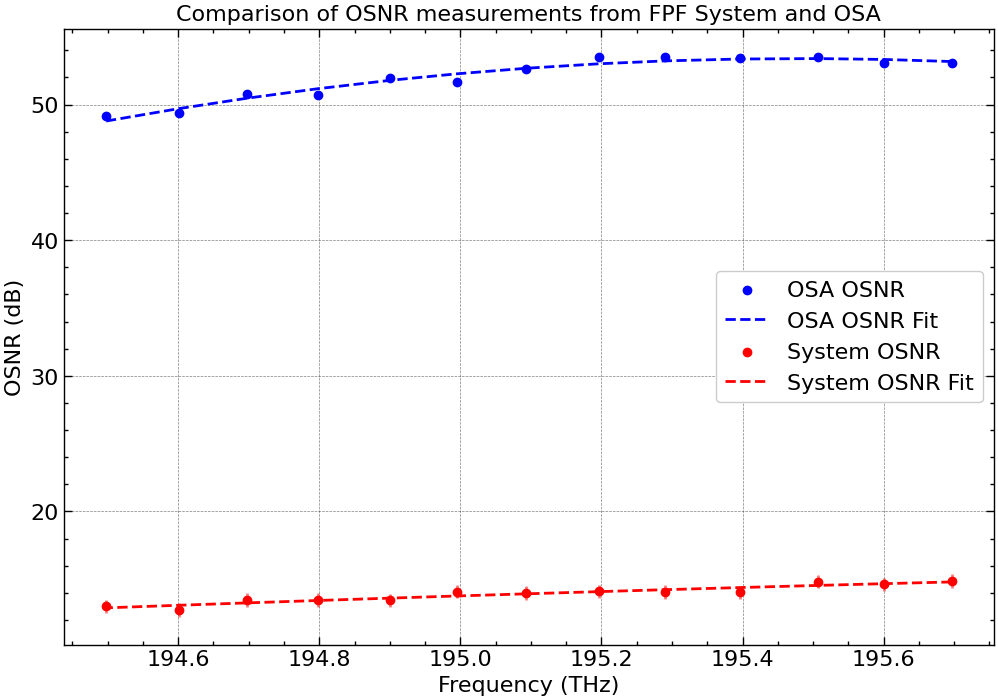

In [15]:
# FITTING

def quadratic(x, A, B, C):
    return A * x**2 + B * x + C

def cubic(x, A, B, C, D):
    return A * x**3 + B * x**2 + C * x + D

def quartic(x, A, B, C, D, E):
    return A * x**4 + B * x**3 + C * x**2 + D * x + E

# OSA

OSA_popt, OSA_pcov = curve_fit(quadratic, channels_THz, OSA_OSNR, p0=[-1, -1, -1])

print('Parameters:')
display(OSA_popt)

print('Covariance Matrix:')
display(OSA_pcov)

print('Errors in each parameter:')
display(np.sqrt(np.diag(OSA_pcov)))

print('% Errors in each parameter:')
display(100 * np.sqrt(np.diag(OSA_pcov)) / np.abs(OSA_popt))

# System

sim_popt, sim_pcov = curve_fit(quadratic, channels_THz, sim_OSNR, p0=[-1, -1, -1], sigma=[1]*len(sim_OSNR), absolute_sigma=True)

print('Parameters:')
display(sim_popt)

print('Covariance Matrix:')
display(sim_pcov)

print('Errors in each parameter:')
display(np.sqrt(np.diag(sim_pcov)))

print('% Errors in each parameter:')
display(100 * np.sqrt(np.diag(sim_pcov)) / np.abs(sim_popt))

# PLOTTING
fig, ax = plt.subplots(
        1,
        1,
        figsize=(12, 8),
    )

osa_OSNR_line = ax.scatter(channels_THz, OSA_OSNR, color='b', marker='o', label='OSA OSNR')
osa_OSNR_fit_line = ax.plot(channels_THz, quadratic(channels_THz, *OSA_popt), color='b', ls='--', label='OSA OSNR Fit')

sim_OSNR_line = ax.scatter(channels_THz, sim_OSNR, color='r', marker='o', label='System OSNR')
ax.errorbar(channels_THz, sim_OSNR, yerr=0.5, ls='', color='r', alpha=0.5)
sim_OSNR_fit_line, = ax.plot(channels_THz, quadratic(channels_THz, *sim_popt), color='r', ls='--', label='System OSNR Fit')

# create custom legend
ax.legend()

#ax1.set_xlim(194.3, 196.3)
#ax1.set_ylim(-90, -30)

ax.set_xlabel('Frequency (THz)')
ax.set_ylabel('OSNR (dB)')

ax.set_title('Comparison of OSNR measurements from FPF System and OSA')

#plt.savefig('OSNR_comparison_onegraph.jpg', bbox_inches='tight')